In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebA-HQ-to-CelebA-mapping.txt
/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebAMask-HQ-pose-anno.txt
/kaggle/input/celebamaskhq/CelebAMask-HQ/README.txt
/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebAMask-HQ-attribute-anno.txt
/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebAMask-HQ-mask-anno/7/15493_neck.png
/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebAMask-HQ-mask-anno/7/15939_l_eye.png
/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebAMask-HQ-mask-anno/7/14505_r_eye.png
/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebAMask-HQ-mask-anno/7/15383_r_eye.png
/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebAMask-HQ-mask-anno/7/14583_l_lip.png
/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebAMask-HQ-mask-anno/7/14432_cloth.png
/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebAMask-HQ-mask-anno/7/14757_nose.png
/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebAMask-HQ-mask-anno/7/14632_skin.png
/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebAMask-HQ-mask-anno/7/1588

In [3]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.4 MB/s eta 0:00:00:00:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39648 sha256=47f1f974ba281a83a74b5b19a9c2276ddd64b1c96a8a0fc1eda11e68e4539695
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [23]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

ImportError: cannot import name 'BaseCAMTarget' from 'pytorch_grad_cam.base_cam' (/usr/local/lib/python3.10/dist-packages/pytorch_grad_cam/base_cam.py)

In [5]:

class CelebADataset(Dataset):
    def __init__(self, root_dir, attr_file, transform=None):
        self.root_dir = root_dir
        self.attr_file = attr_file
        self.transform = transform

        # Read attribute file
        self.attrs = pd.read_csv(attr_file, delim_whitespace=True, skiprows=1)
        self.attrs = self.attrs.iloc[:, :40]  # Select the first 40 attributes
        self.attrs.replace(to_replace=-1, value=0, inplace=True)  # Replace -1 with 0
        self.images = self.attrs.index.tolist()  # Image names

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        labels = self.attrs.iloc[idx].values.astype(np.float32)
        return image, labels


In [6]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [7]:
root_dir = '/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebA-HQ-img'  # Update with your path
attr_file = '/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebAMask-HQ-attribute-anno.txt'  # Update with your path
dataset = CelebADataset(root_dir, attr_file, transform=transform)

In [8]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [9]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, 40),  # Output 40 labels
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_loss = float('inf')
epochs = 3

In [11]:
for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    print(f"Epoch {epoch+1}/{epochs}")
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    y_true = []
    y_pred = []
    for images, labels in tqdm(val_loader, desc="Validating", leave=False):
        with torch.no_grad():
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = (outputs > 0.5).float()
            y_true.append(labels.cpu().numpy())
            y_pred.append(preds.cpu().numpy())

    # Calculate metrics
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_multilabel_model.pth')
        print(f"Saved Best Model at Epoch {epoch+1}")

Epoch 1/3


Train Loss: 0.3029, Val Loss: 0.2517
Saved Best Model at Epoch 1
Epoch 2/3


Train Loss: 0.2339, Val Loss: 0.2343
Saved Best Model at Epoch 2
Epoch 3/3


Train Loss: 0.2068, Val Loss: 0.2306
Saved Best Model at Epoch 3


In [12]:
loaded_model = CNNModel().to(device)
loaded_model.load_state_dict(torch.load('best_multilabel_model.pth'))
loaded_model.eval()

<ipython-input-12-559a36420d28>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('best_multilabel_model.pth'))


CNNModel(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=32768, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=40, bias=True)
    (3): Sigmoid()
  )
)

In [13]:
def predict_image(image_path, model):
    model.eval()
    target_image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image_tensor = transform(target_image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor).cpu().numpy()[0]
        predictions = (output > 0.5).astype(int)

    return predictions, output

In [19]:
example_image_path = '/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebA-HQ-img/0.jpg'  # Update with the path to an example image
predictions, confidences = predict_image(example_image_path, loaded_model)
print("Predictions:", predictions)
print("Confidences:", confidences)

Predictions: [0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1
 0 0 1]
Confidences: [7.2929638e-06 7.3938161e-01 9.6071976e-01 5.9143998e-02 2.0304983e-06
 1.8470595e-05 6.7829233e-01 4.0937752e-02 4.1473654e-04 6.6167668e-02
 1.6866995e-04 9.0989059e-01 1.5358014e-01 5.5956905e-04 6.9722597e-04
 6.5898598e-04 1.9152674e-06 1.0464982e-05 9.7567344e-01 8.9976865e-01
 3.5368116e-06 9.9922371e-01 4.4491712e-06 4.4288763e-01 9.9998057e-01
 5.1530540e-02 2.0101939e-03 4.9945879e-01 5.5592228e-03 7.4176192e-02
 3.6351951e-06 9.9217999e-01 1.7503430e-01 7.2042185e-01 2.8952128e-01
 6.8578805e-04 9.7678876e-01 4.7854853e-01 1.8685681e-04 9.9173170e-01]


In [30]:
def generate_heatmap_for_label(image_path, model, target_layer, label_index):
    model.eval()
    target_image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image_tensor = transform(target_image).unsqueeze(0).to(device)

    # Initialize ScoreCAM
    cam = ScoreCAM(model=model, target_layers=[target_layer])

    # Define a custom target for the specific label
    def target_specific_label(model_output):
        # Ensure model_output has at least 2 dimensions
        if model_output.dim() == 1:
            model_output = model_output.unsqueeze(0)
        return model_output[:, label_index]

    # Generate CAM for the specific label
    grayscale_cam = cam(input_tensor=image_tensor, targets=[target_specific_label])[0, :]

    # Convert tensor to image format for visualization
    rgb_image = np.array(target_image.resize((128, 128))) / 255.0
    heatmap = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

    # Show heatmap
    plt.figure(figsize=(6, 6))
    plt.imshow(heatmap)
    plt.axis('off')
    plt.title(f'ScoreCAM Heatmap for Label {label_index}')
    plt.show()


100%|██████████| 8/8 [00:00<00:00, 81.12it/s]


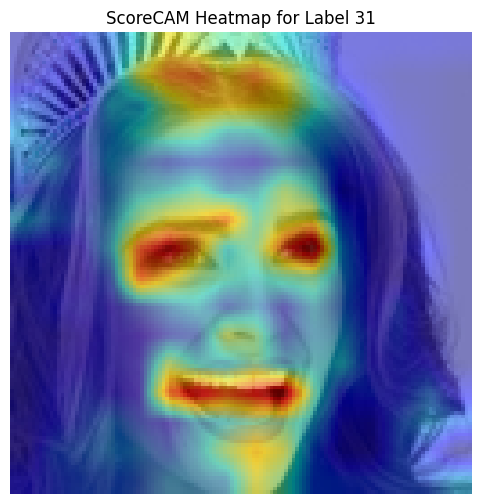

In [45]:
example_image_path = '/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebA-HQ-img/0.jpg'  # Update with the path to an example imag

label_index = 31  # 'Smiling'
generate_heatmap_for_label(example_image_path, loaded_model, target_layer=loaded_model.conv[-1], label_index=label_index)